In [2]:
import flopy as fp
import numpy as np
import geopandas as gp
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from flopy.utils.gridintersect import GridIntersect
from flopy.utils import Raster
import shapely
from shapely.geometry import *
from shutil import copyfile


sys.path.append("../../modules")
# hand made functions
from Rouss import *

sys.path.append("../../Model_val/upscalling/")
from upscalling_functions import *

flopy is installed in C:\Users\emmal\Anaconda3\lib\site-packages\flopy


In [3]:
model_dir = "workspace"
model_name = "pest_2D_R"
exe_name="../../exe/mf6"

In [4]:
############# set every external variables (bcs and spatial parameters)

MNT_path="../../data/surfaces_geoter_decoup/TOPO (inf 0 en mer).asc"
Agly_path= "../../data/Fleuves/Agly_ludo.shp" # path to Agly
Tet_path= "../../data/Fleuves/Tet_ludo.shp"
Rea_path = "../../data/Fleuves/Reart_ludo.shp"
Tech_path = "../../data/Fleuves/Tech_ludo.shp"
Bol_path = "../../data/Fleuves/Boules_ludo.shp"
Cant_path = "../../data/Fleuves/Cant_ludo.shp"

top,BOT,idomain,delr,delc = read_pickle("workspace/export_dis") # import data from the DIS notebook

### spatial parameters
x0,x1,y0,y1 = Raster.load(MNT_path).bounds

ncol = idomain.shape[1]
nrow = idomain.shape[0]
nlay=1
grid = fp.discretization.StructuredGrid(delc,delr,xoff=x0,yoff=y0) # create a grid identical to the dis package, will be used
                                                                   # to pre-process data
ix = GridIntersect(grid)

### Do a list of all active cells
lst_domain = []
for ilay in range(nlay):
    for irow in range(nrow):
        for icol in range(ncol):
            if idomain[irow,icol] == 1:
                lst_domain.append((ilay,irow,icol))
idomain = idomain.reshape(nrow*ncol)

### recharge from rain
rch_path="../../data/recharge/recharge_p.tif"
rcha = rspl_rast(rch_path,grid) # resample to grid
rcha[rcha<0]=np.mean(rcha[rcha>0]) # replace negative values by a mean
rcha[np.abs(idomain).sum(0)==0]=0 # remove some rch

### recharge irrig
irr_path = "../../data/recharge/rast_irr.asc"
irri = rspl_rast(irr_path,grid)
irri[irri<0]=0
irri *= 1/1000/365/86400 # from mm/yr to m/s
np.savetxt(os.path.join(model_dir,"irr.txt"),irri)
# irrigation zones
list_val = np.unique(irri)[1:]
irr_z=irri
for i,ival in enumerate(list_val):
    irr_z[irr_z==ival]=i+1
np.savetxt(os.path.join(model_dir,"zone_irr.txt"),irr_z)

### BC sea
BCsea_path = "../../data/shp/sea_bc_extended.shp"
BC_sea = gp.read_file(BCsea_path)
lst_chd = gp2cellids(grid,BC_sea,idomain,type="polygon") # extract cellids from the BC at the sea and make these cells active
# attribute a constant head at all the cells in the lst_chd
CHD = 0.1; chd_lst=[];
for x in lst_chd:
    chd_lst.append((x,CHD))

### BC etangs
BCetangs_path = "../../data/shp/Surface_hydro/SURFACE_HYDROGRAPHIQUE.SHP"
Bcet = gp.read_file(BCetangs_path)
etangs = Bcet[(Bcet["TOPONYME"]=="étang de canet") | (Bcet["TOPONYME"]=="étang de leucate")]
# extract cellids from the BC 
etangs_chd = gp2cellids(grid,etangs.dissolve(by="NATURE"),idomain)
# attribute a constant head
elev = 0; et_lst=[];
for x in etangs_chd:
    et_lst.append((x,elev,1))  

#remove some rch
idomain = idomain.reshape(nrow,ncol)
rcha[idomain!=1]=0 # remove some rch
for cell in etangs_chd:
    rcha[cell[1],cell[2]]=0
idomain = idomain.reshape(nrow*ncol)    
    
# BC Agly
Agy_chd = Complete_riv(Agly_path,"../../data/Fleuves/stations_agly.csv",us=28,ds=0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
# BC Tet
Tet_chd = Complete_riv(Tet_path,"../../data/Fleuves/stations_tet2.csv",us=180,ds=0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
#BC Boul
Bol_chd = Complete_riv(Bol_path,"../../data/Fleuves/stations_bol.csv",us=180,ds=0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
## BC Reart
Rea_chd = Complete_riv(Rea_path,"../../data/Fleuves/stations_reart.csv",us=130,ds=0,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
## BC Cant
Cant_chd = Complete_riv(Cant_path,"../../data/Fleuves/stations_cant.csv",us=135,ds=0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)
# BC Tech
Tech_chd = Complete_riv(Tech_path,"../../data/Fleuves/stations_tech.csv",us=170,ds=0.1,lst_chd=lst_chd,lst_domain=lst_domain,grid=grid)

#from chd to river
lst_riv_chd=[Agy_chd,Tech_chd,Cant_chd,Rea_chd,Tet_chd,Bol_chd]
cond = [0.005,0.005,0.005,0.005,0.005,0.005]
for iriv in range(len(lst_riv_chd)):
    chd2riv(lst_riv_chd[iriv],cond[iriv],2)
    
### extraction
path = "../../data/prélèvements/donnees_sandra/SynthèseSLanini_data_Prelevements_1987-2018.shp"
V_col = "VOL_2013"
GDB = gp.read_file(path)
GDB = GDB[(GDB["NAPPE_CAPT"] != "IRRIGATION") & (GDB["geometry"] != None)]
layer = 0
stress_data_well = importWells(GDB,grid,lst_domain,V_col=V_col,layer=layer)

### prélèvements agricoles
path = "../../data/prélèvements/prlvm_agri.asc"
p_agri = rspl_rast(path,grid)
p_agri *= 1/1000/365/86400
p_agri *= 1.25

### K
k = np.ones([nrow,ncol])*1e-5 #base conductivity
np.savetxt(os.path.join(model_dir,"k.txt"),k)
# copyfile("../../Modeles2D/test_premier_model/working/k.txt","workspace/k.txt")

### Corbières
layer = 0
BDcells = cellidBD(idomain.reshape(nlay,nrow,ncol),layer)
poly = Polygon([(685e3,618.7e4),(685e3,619.5e4),(696e3,619.5e4),(696e3,618.7e4)])

Corb_spd = []
Corb_lst = []
flux = 0.2 # total influx
res = ix.intersect_polygon(poly) #intersect btw poly and grid
for cellid in res.cellids:
    cell = (layer,cellid[0],cellid[1])
    if cell in BDcells:
        Corb_lst.append(cell)
n_cells = len(Corb_lst)

for cell in Corb_lst:
    Corb_spd.append((cell,flux/n_cells))
    
### Thuir
layer = 0
poly = Polygon([(674e3,616.8e4),(674e3,617.4e4),(678e3,617.4e4),(678e3,616.8e4)])

plio_chd = []
for cellid in ix.intersect_polygon(poly).cellids:
    cell = (layer,cellid[0],cellid[1])
    if cell in BDcells:
        plio_chd.append((cell,120))

In [5]:
####### obs

# control piezos
piez_path="../../data/piezos/pz_hydriad.xlsx"
#import the data using this function (path,modelgrid, sheetname of the data,piezometric level column, x and y coor (in L93 !))
Control_pz = importControlPz(piez_path,grid,sheetName="2012",np_col="NP_Avril2013",x_col="x",y_col="y")

il,ir,ic = np.where([Control_pz!=0]) #indice where there's an observation

lst_pts=[]
for o in range(il.shape[0]):
    cell = (il[o],ir[o],ic[o])
    if cell in lst_domain:
        lst_pts.append((il[o],ir[o],ic[o]))
    
## carte pz
np.random.seed(2000)
data = "../../data/cartes_pz/Piézo_Pliocène_1990_V2.grd"
carte_pz = rspl_rast(data,grid)
carte_pz[idomain.reshape(nrow,ncol)!=1]=None
carte_pz[:,130:]=None
### sample points from carte_pz
n = 200
lst_pts_carte_pc=[]
i_n = 0
while i_n < n:
    ir = np.random.randint(0,nrow)
    ic = np.random.randint(0,ncol)
    if ~np.isnan(carte_pz[ir,ic]) and (idomain[ir*ncol+ic]==1):
        i_n += 1
        lst_pts_carte_pc.append((0,ir,ic))   

#obs lists
obs_lst1=[]
for pts in lst_pts:
    obs_lst1.append(("0_{}_{}".format(pts[1],pts[2]),"HEAD",pts))
    
obs_lst_carte_pc=[]
for pts in lst_pts_carte_pc:
    obs_lst_carte_pc.append(("0_{}_{}".format(pts[1],pts[2]),"HEAD",pts))
     
obs_recarray = {('heads.csv'):obs_lst1,
               ("heads_pcmap.csv"):obs_lst_carte_pc}

C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:312: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\emmal\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


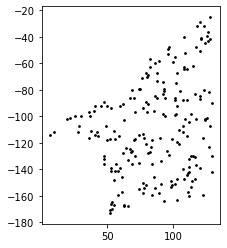

In [6]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_aspect("equal")
for pts in lst_pts_carte_pc:
    plt.scatter(pts[2],-pts[1],s=3,c="k")

In [7]:
######## set packages
sim = fp.mf6.MFSimulation(sim_name=model_name, version='mf6', exe_name=exe_name, sim_ws=model_dir)
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,model_nam_file='{}.nam'.format(model_name))
dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=BOT,xorigin=x0,yorigin=y0,idomain=idomain)
tdis = fp.mf6.ModflowTdis(sim, time_units='SECONDS',perioddata=[[1.0, 1, 1.]])
ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity='simple')

# initial conditions
ic   = fp.mf6.ModflowGwfic(gwf,strt=BOT+1)
# output control
oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            saverecord=[('HEAD', 'LAST'),
                                        ('BUDGET', 'ALL')],
                            printrecord=[('BUDGET', 'ALL')])
obs_package = fp.mf6.ModflowUtlobs(gwf, pname='head_obs', filename='{}.obs'.format(model_name), 
                                      digits=10, print_input=True,
                                      continuous=obs_recarray)

# nodeflowproperty
npf  = fp.mf6.ModflowGwfnpf(gwf, icelltype=0, k=["k.txt"], save_flows=True,save_specific_discharge=True)

# recharge 
rch  = fp.mf6.ModflowGwfrcha(gwf, recharge = rcha/1000/365/86400,save_flows=True)

# agriculture uptakes
p_ag = fp.mf6.ModflowGwfrcha(gwf,pname="p_ag",filename="p_ag.rch",recharge = p_agri,save_flows=True)

#recharge from irrigation
irr = fp.mf6.ModflowGwfrcha(gwf,pname="irr",filename="irr.rch",recharge="irr.txt",save_flows=True)

# wells
wel = fp.mf6.ModflowGwfwel(gwf, pname="wel",filename="wel.wel",
                           stress_period_data=stress_data_well, maxbound=len(stress_data_well),save_flows=True)

#Corb
Corb = fp.mf6.ModflowGwfwel(gwf,pname="Corb",filename="Corb.wel",maxbound=len(Corb_spd),
                            stress_period_data=Corb_spd,save_flows=True)

#Thuir
thuir = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='thuir', filename="thuir.chd", maxbound=len(plio_chd), 
                                                       stress_period_data={0: plio_chd}, save_flows=True)

# constant heads packages
chd = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='sea', filename="sea.chd", maxbound=len(chd_lst), 
                                               stress_period_data={0: chd_lst}, save_flows=True)

#rivers
etangs = fp.mf6.modflow.ModflowGwfdrn(gwf, pname='eta', filename="eta.drn", maxbound=len(et_lst), 
                                               stress_period_data={0: et_lst}, save_flows=True)

Riv1 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='agy', filename="agy.riv", maxbound=len(Agy_chd), 
                                              stress_period_data={0: Agy_chd}, save_flows=True)

Riv2 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Tet', filename="Tet.riv", maxbound=len(Tet_chd), 
                                               stress_period_data={0: Tet_chd}, save_flows=True)

Riv3 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Rea', filename="Rea.riv", maxbound=len(Rea_chd), 
                                               stress_period_data={0: Rea_chd}, save_flows=True)

Riv6 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Cant', filename="Cant.riv", maxbound=len(Cant_chd), 
                                               stress_period_data={0: Cant_chd}, save_flows=True)

Riv4 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Tech', filename="Tech.riv", maxbound=len(Tech_chd), 
                                               stress_period_data={0: Tech_chd}, save_flows=True)

Riv5 = fp.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, pname='Bol', filename="Bol.riv", maxbound=len(Bol_chd), 
                                               stress_period_data={0: Bol_chd}, save_flows=True)

In [8]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model pest_2D_R...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package head_obs...
    writing package npf...
    writing package rcha...
    writing package p_ag...
    writing package irr...
    writing package wel...
    writing package corb...
    writing package thuir...
    writing package sea...
    writing package eta...
    writing package agy...
    writing package tet...
    writing package rea...
    writing package cant...
    writing package tech...
    writing package bol...
FloPy is using the following  executable to run the model: ../../exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 15:37:31 with IFOR

(True, [])

In [9]:
head = get_heads(model_name,model_dir)

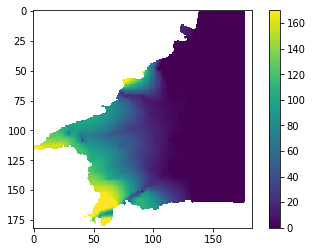

In [10]:
head[head>1000] = None 
plt.imshow(head[0],vmin=0,vmax=170)
plt.colorbar()

In [11]:
# change observations values to real observations values

file = open(os.path.join(model_dir,"heads2.csv"),"w")
with open(os.path.join(model_dir,"heads.csv")) as f:
    file.write(f.readlines()[0])
    file.write("1.0000000")
    for i,j,k in lst_pts:
        file.write("," + str(Control_pz[j,k])) # observations from Control_pz replace obs from modflow
file.close()

#copy everything and save on head.csv
fileout = os.path.join(model_dir,"heads2.csv")
file = os.path.join(model_dir,"heads.csv")
from shutil import copyfile
copyfile(fileout, file) # copy 
os.remove(fileout) # delete tmp file



file = open(os.path.join(model_dir,"heads2.csv"),"w")
with open(os.path.join(model_dir,"heads_pcmap.csv")) as f:
    file.write(f.readlines()[0])
    file.write("1.0000000")
    for i,j,k in lst_pts_carte_pc:
        file.write("," + str(carte_pz[j,k])) # observations from carte_pz replace obs output
file.close()

#copy everything and save on head_pcmap.csv
fileout = os.path.join(model_dir,"heads2.csv")
file = os.path.join(model_dir,"heads_pcmap.csv")
from shutil import copyfile
copyfile(fileout, file) # copy 
os.remove(fileout) # delete tmp file

Text(0.5, 1.0, 'Observations location from Piezometrics maps')

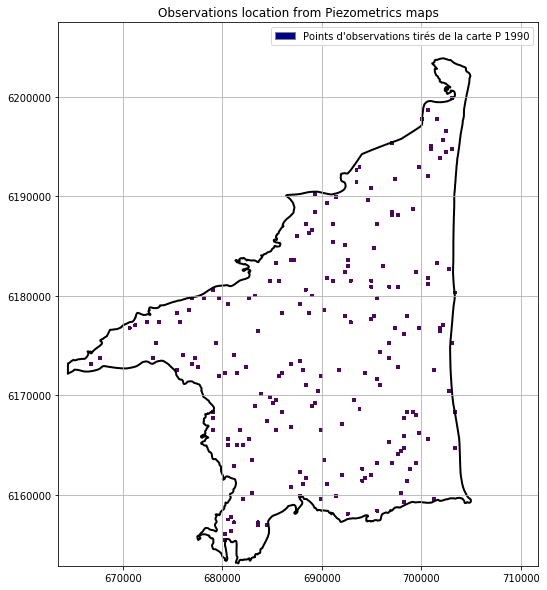

In [20]:
arr=np.zeros([nrow,ncol])

for i in lst_pts_carte_pc:
    arr[i[1],i[2]]=1
arr[arr==0]=None

# plot obs
fig = plt.figure(figsize=(10,10))
layer = 0
ax1  = plt.subplot(1,1,1, aspect='equal')
ml = fp.plot.PlotMapView(model=gwf,layer=layer)
f1 = ml.plot_array(arr,masked_values=[0],alpha=0.8)
fp.plot.plot_shapefile("../../data/shp/limiteModeleRoussillon_poly.shp",facecolor="none",edgecolor="k",linewidth=2)
ax1.grid()

ax1.set_xlim(x0-1e3,x1-2.3e4)

import matplotlib.patches as mpatches
#legend
pQ = mpatches.Rectangle((0, 0), 1, 1,ec="grey", fc="darkblue",alpha=1)
proxy = [pQ]
plt.legend(proxy,["Points d'observations tirés de la carte P 1990"])

plt.title("Observations location from Piezometrics maps")